In [53]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# Seed para que las redes con iguales parametros no generen resultados aleatorios y tener repetibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Para las graficas importamos matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Función para plotear
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

#Función Rounded Accuracy
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

    
#Traemos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full_normalized = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full_normalized[:-5000], X_train_full_normalized[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#Función para ver los resultados de las reconstrucciones
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [54]:
#definimos la operacion kernel como un kernel gaussiano

def rbf_kernel(X, Y, sigma=1.0):
    X_expanded = tf.expand_dims(X, axis=1)  # Shape: (batch_size, 1, latent_dim)
    Y_expanded = tf.expand_dims(Y, axis=0)  # Shape: (1, batch_size, latent_dim)
    squared_distance = tf.reduce_sum(tf.square(X_expanded - Y_expanded), axis=2)
    return tf.exp(-squared_distance / (2 * sigma ** 2))

#definimos la operacion MMD
def compute_mmd(z, z_prior, kernel_fn):

    # Calcula los kernels
    K_zz = kernel_fn(z, z)
    K_zz_prior = kernel_fn(z, z_prior)
    K_prior_prior = kernel_fn(z_prior, z_prior)

    # Calcula MMD
    mmd = tf.reduce_mean(K_zz) + tf.reduce_mean(K_prior_prior) - 2 * tf.reduce_mean(K_zz_prior)
    return mmd


In [55]:
#Definimos una funcion para crear el encoder con la API funcional
def build_encoder(latent_dim):
    encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = keras.layers.RandomFlip(mode="horizontal")(encoder_inputs)#Usamos unas capas de random flip y random contrast para aumentar artificialmente los datos de entrada
    x = keras.layers.RandomContrast(factor=0.2)(x)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder

#Definimos la función que crea el decoder con la API funcional
def build_decoder(latent_dim):
    decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(7*7*64, activation='relu')(decoder_inputs)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder

#Esta clase se crea para introducir las propiedades del autoencode variacional, en particular el loss probabilistico
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, alpha=0.01,sigma=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha #Este parametro se usara para darle peso a la regularizacion con el loss KL
        self.sigma = sigma  # Kernel bandwidth
        
#La funcion call de la clase VAE calcula el loss por MMD usando los datos de salida del encoder, y luego los añade
#usado el metrodo add_loss
    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        z_prior = tf.random.normal(shape=tf.shape(z))
        mmd_loss = self.alpha * compute_mmd(z, z_prior, lambda x, y: rbf_kernel(x, y, sigma=self.sigma))
        self.add_loss(mmd_loss)
        return reconstructed
    
#Esta funcion se usa en la función call para convertir las muestras del espacio latente en un conjunto continuo y diferenciable, y asi 
#el espacio latente se convierte en la nube de probabilidad
    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * .5) + z_mean

#Para poder usar el parametro de escalado y darle pesos a los diferentes loss creamos una clase para un loss custom escalado
class ScaledBinaryCrossentropy:
    #la funcion init para inicializar el factor de escalada
    def __init__(self, scale=1.0):
        self.scale = scale
        
    #En la funcion call se calcula la perdida escalada y la retorna
    def __call__(self, y_true, y_pred):
        # Calcula la binary crossentropy
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Retorna la binary crossentropy escalada
        return self.scale * bce

In [56]:
#Luego de definir las funcions y la clase VAE, se crea y compila  el modelo
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 8
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
#Definimos los pesos que llevaran los loss
alpha = 0.6
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 0.1 
#Usamos la clase VAE para definir el modelo
vae = VAE(encoder, decoder,alpha,sigma)
#Se crea el callback para el learning rate scheduling
#piecewise_constant_fn = piecewise_constant([100,200,300], [0.1, 0.01, 0.005,0.001])
#scheduler=keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

#Creamos el objeto loss que va a calcular la crossentropia escalada
loss2=ScaledBinaryCrossentropy(beta)
#Compilamos
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

In [58]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))#,callbacks=[scheduler])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.2338 - rounded_accuracy: 0.7648 - val_loss: 0.1719 - val_rounded_accuracy: 0.8886
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1613 - rounded_accuracy: 0.9080 - val_loss: 0.1656 - val_rounded_accuracy: 0.9004
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1582 - rounded_accuracy: 0.9143 - val_loss: 0.1617 - val_rounded_accuracy: 0.9088
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1567 - rounded_accuracy: 0.9173 - val_loss: 0.1601 - val_rounded_accuracy: 0.9117
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1557 - rounded_accuracy: 0.9194 - val_loss: 0.1583 - val_rounded_accuracy: 0.9158
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1550 - rounded_accuracy: 0.9211 - val_loss: 0.1575 - val_rounded_accuracy: 0.9176
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1544 - rounded_accuracy: 0.9224 - val_loss: 0.1561 

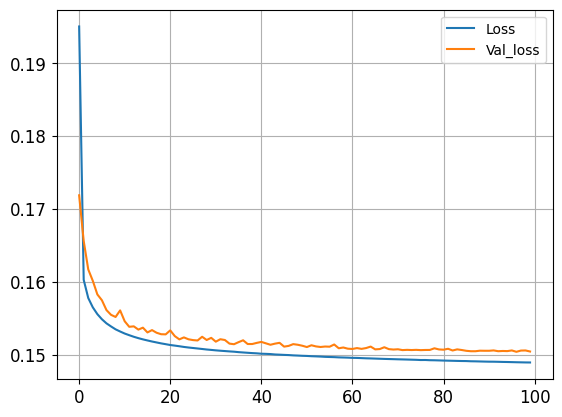

In [62]:
#Graficamos el loss de entrenamiento y validación
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.49,0.52)
plt.legend()
plt.show()

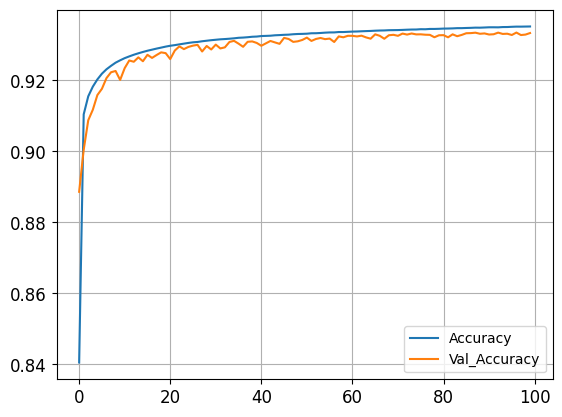

In [63]:
#Graficamos el accuracy de entrenamiento y el de validación

plt.plot(history.history["rounded_accuracy"],label="Accuracy")
plt.plot(history.history["val_rounded_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.7,0.75)
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


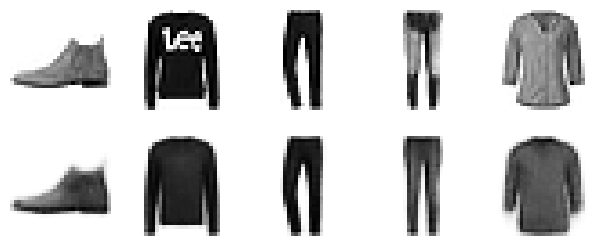

In [64]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae)
plt.show()

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


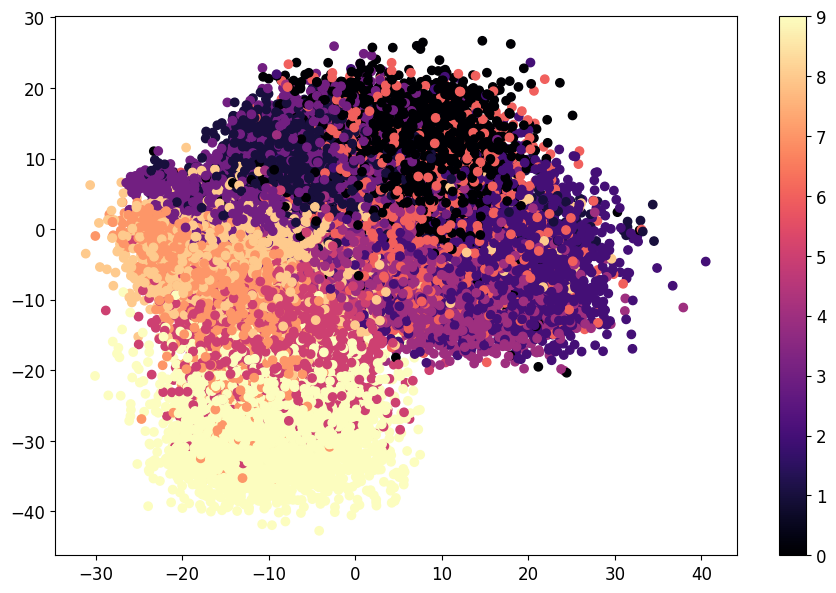

In [65]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


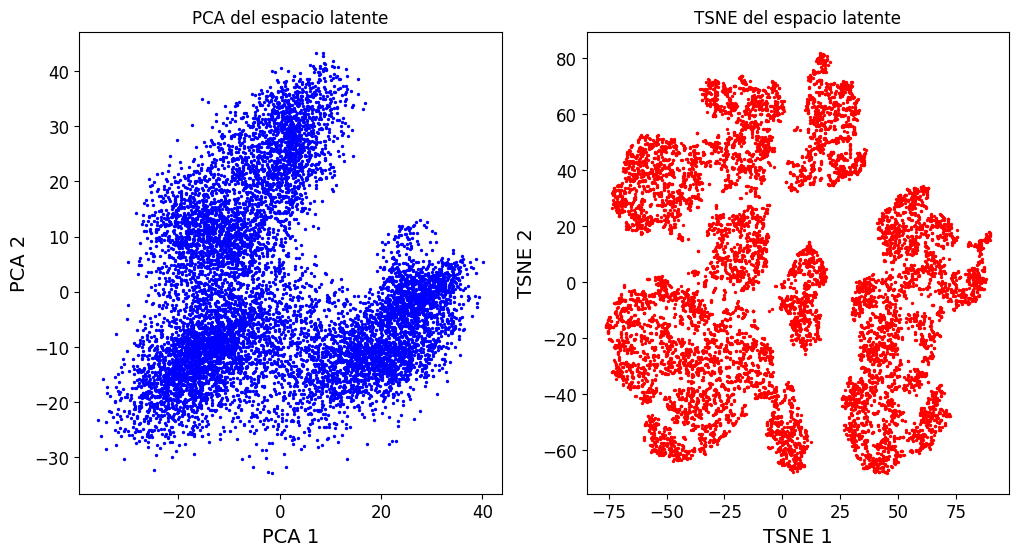

In [66]:
#Para revisar el espacio latente usamos PCA y TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Extraer los valores latentes
z_mean, _ = vae.encoder.predict(X_test)

# Aplicar PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)

# Aplicar TSNE
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z_mean)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# PCA
plt.subplot(1, 2, 1)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c='blue', s=2)
plt.title('PCA del espacio latente')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# TSNE
plt.subplot(1, 2, 2)
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c='red', s=2)
plt.title('TSNE del espacio latente')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')

plt.show()

**Por comparación vamos a revisar que pasa cuando no se añade el MMD, y cuando el ancho de banda es muy pequeño y muy grande**

In [67]:
#Definimos los pesos que llevaran los loss
alpha = 0
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 0.1 
#Usamos la clase VAE para definir el modelo
vae = VAE(encoder, decoder,alpha,sigma)
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

In [68]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))#,callbacks=[scheduler])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.1113 - rounded_accuracy: 0.9350 - val_loss: 0.1127 - val_rounded_accuracy: 0.9334
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1113 - rounded_accuracy: 0.9350 - val_loss: 0.1127 - val_rounded_accuracy: 0.9337
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1113 - rounded_accuracy: 0.9351 - val_loss: 0.1128 - val_rounded_accuracy: 0.9332
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1113 - rounded_accuracy: 0.9351 - val_loss: 0.1126 - val_rounded_accuracy: 0.9336
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1113 - rounded_accuracy: 0.9351 - val_loss: 0.1128 - val_rounded_accuracy: 0.9329
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1112 - rounded_accuracy: 0.9351 - val_loss: 0.1127 - val_rounded_accuracy: 0.9332
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1112 - rounded_accuracy: 0.9352 - val_loss: 0.1127 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


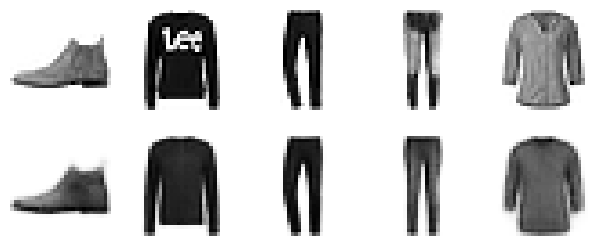

In [69]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae)
plt.show()

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


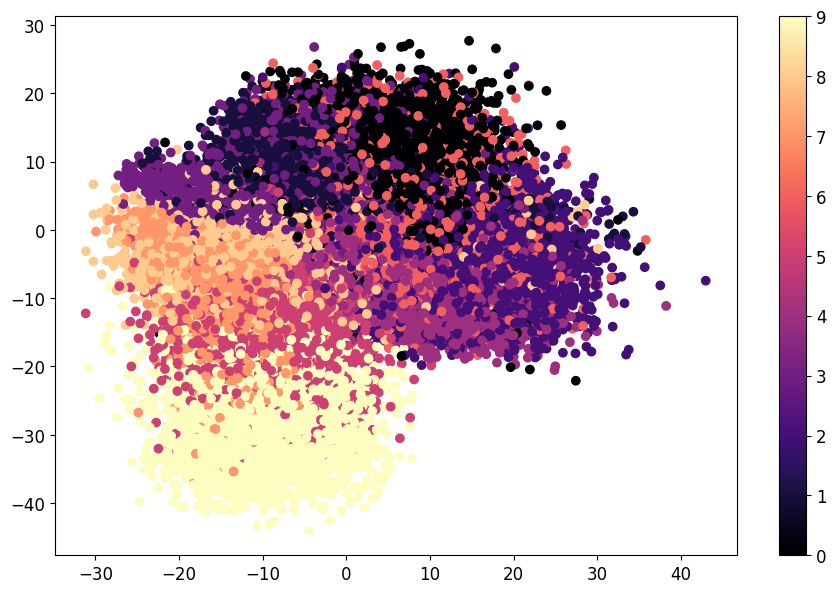

In [70]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

**Verificamos que pasa si el sigma es muy pequeño**

In [71]:
#Definimos los pesos que llevaran los loss
alpha = 0.5
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 0.001 
#Usamos la clase VAE para definir el modelo
vae = VAE(encoder, decoder,alpha,sigma)
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

In [72]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))#,callbacks=[scheduler])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.1418 - rounded_accuracy: 0.9368 - val_loss: 0.1438 - val_rounded_accuracy: 0.9338
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1418 - rounded_accuracy: 0.9368 - val_loss: 0.1436 - val_rounded_accuracy: 0.9343
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1418 - rounded_accuracy: 0.9368 - val_loss: 0.1437 - val_rounded_accuracy: 0.9344
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1418 - rounded_accuracy: 0.9368 - val_loss: 0.1437 - val_rounded_accuracy: 0.9341
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1417 - rounded_accuracy: 0.9369 - val_loss: 0.1437 - val_rounded_accuracy: 0.9340
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1417 - rounded_accuracy: 0.9369 - val_loss: 0.1438 - val_rounded_accuracy: 0.9337
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1417 - rounded_accuracy: 0.9369 - val_loss: 0.1442 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


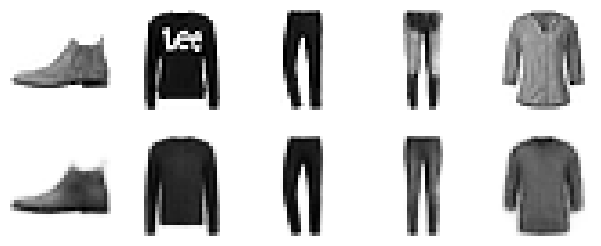

In [74]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae)
plt.show()

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


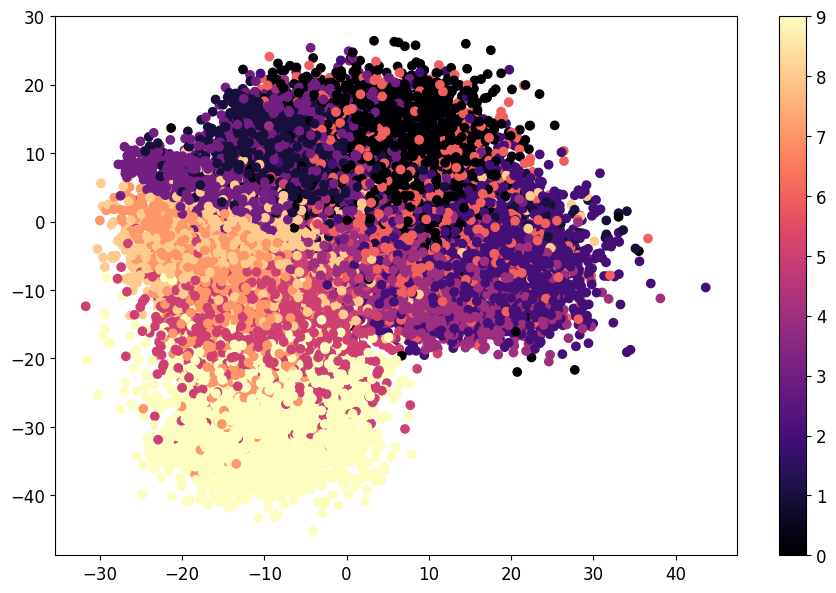

In [73]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

**Ahora con un sigma muy grande**

In [75]:
#Definimos los pesos que llevaran los loss
alpha = 0.5
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 1000 
#Usamos la clase VAE para definir el modelo
vae = VAE(encoder, decoder,alpha,sigma)
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

In [ ]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))#,callbacks=[scheduler])

Epoch 1/100
 907/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1102 - rounded_accuracy: 0.9377

In [ ]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae)
plt.show()

In [ ]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

# Discusion